# TorchQuad

**Goal:** Understand the `pytorch` library used for numerical integration.

**Description:** The log evidence integral is evaluated using quadrature (numerical integration) in GeneBayes.

Here, I will explore how this library works to better understand its utility. The `torchquad` library supports the following methods of integration:

1. Trapezoid rule: interpolation between two points
2. Simpson's rule: interpolation between three points
3. Boole's rule: interpolation between five points
4. Gaussian Quadrature: uses orthogonal Legendre polynomials
5. Monte Carlo: stochastic method
6. VEGAS+: adaptive Monte Carlo method

In [70]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

import torch

from torchquad import set_up_backend
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS
import torchquad

from functools import partial

In [71]:
set_up_backend('torch', data_type='float32')

09:28:30|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


We can test the precision of the numerical integration method by testing it against an analytical result. Consider the function

$$f(x) = x^2 e^x$$

Integrating over the domain $[0,2]$, we obtain

$$\int_0^2 f(x) \,dx = 2(e^2 - 1) \approx 12.77811$$

In [72]:
def f(x):
    
    return torch.exp(x) * torch.pow(x, 2)

def print_error(result, solution):

    print(f'Results: {result.item()}')
    print(f'Absolute Error: {(torch.abs(result - solution).item()):.8e}')
    print(f'Relative Error: {(torch.abs((result - solution) / solution).item()):.8e}')

solution = 2 * (torch.exp(torch.tensor([2.0])) - 1)

In [73]:
integration_domain = torch.tensor([[0.0, 2.0]])
boole = Boole()

result = boole.integrate(f, dim=1, N=101, integration_domain=integration_domain)
print_error(result, solution)

Results: 12.778111457824707
Absolute Error: 9.53674316e-07
Relative Error: 7.46334266e-08


There is an option to use just-in-time (JIT) compilation with `pytorch` to increase the speed of integration when using the same arguments for integration multiple times.

In [74]:
boole_compiled = torch.jit.trace(lambda dom: boole.integrate(f, dim=1, N=101, integration_domain=dom), (integration_domain,))
boole_compiled(integration_domain)
boole_compiled(torch.tensor([[0.0, 4.0]]))

tensor(543.9815)

In [75]:
def f(y, sigma_2, m, s_2, u):

    y_u = (1 / np.sqrt(2 * np.pi * sigma_2)) * torch.exp(-(1.0 / (2.0 * sigma_2)) * torch.pow(y - u, 2))
    u_x = (1 / np.sqrt(2 * np.pi * s_2)) * torch.exp(-(1.0 / (2.0 * s_2)) * torch.pow(u - m, 2))
    return y_u * u_x


In [125]:
integration_domain = torch.tensor([[-30.0, 30.0]])
boole = Boole()

boole.integrate(partial(
    f,
    torch.tensor(3.0), torch.tensor(1.0),
    torch.tensor(0.0), torch.tensor(1.0)
), dim=1, N=101, integration_domain=integration_domain)

tensor(0.0299)

In [126]:
sigma_2 = torch.tensor(2.0)
m = torch.tensor(-1.0)
s_2 = torch.tensor(3.0)

boole_compiled = torch.jit.trace(lambda y: boole.integrate(partial(
    f, y, sigma_2, m, s_2
), dim=1, N=10001, integration_domain=integration_domain), (torch.tensor(3.0),))

In [128]:
output = torch.tensor([boole_compiled(x) for x in torch.linspace(-10.0, 10.0, 1000)])

In [133]:
m_y = m.numpy()
s_y = (s_2 + sigma_2).numpy()

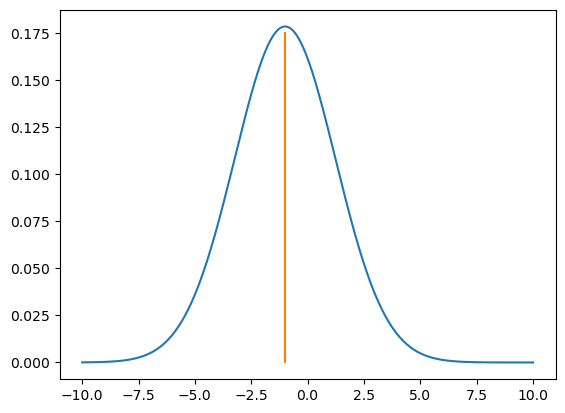

In [134]:
plt.plot(np.linspace(-10.0, 10.0, 1000), output.numpy())
plt.plot(np.repeat(m_y, 100), np.linspace(0, 0.175, 100))

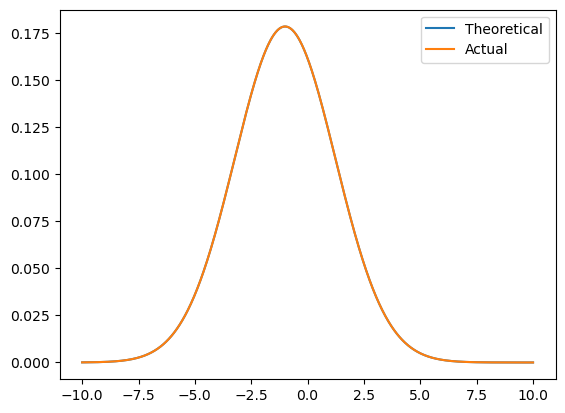

In [136]:
distribution = sp.stats.norm(loc=m_y, scale=np.sqrt(s_y))
Y = np.linspace(-10, 10, 1000)
plt.plot(Y, distribution.pdf(Y), label='Theoretical')
plt.plot(np.linspace(-10.0, 10.0, 1000), output.numpy(), label='Actual')
plt.legend()